In [8]:
import torch.nn as nn
from transformers import BertModel

# Bert

class BertClassifier(nn.Module):
    def __init__(self, bert_config, num_labels):
        super().__init__()
        # 定义BERT模型
        self.bert = BertModel(config=bert_config)
        # 定义Dropout层
        self.dropout = nn.Dropout(p=0.2)  # Dropout概率为0.2
        # 定义分类器
        self.classifier = nn.Linear(bert_config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask, token_type_ids):
        # BERT的输出
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        # 取[CLS]位置的pooled output
        pooled = bert_output[1]
        # 在pooled output上应用Dropout
        pooled = self.dropout(pooled)
        # 分类
        logits = self.classifier(pooled)
        # 返回结果
        return logits


# Bert+BiLSTM，用法与BertClassifier一样，可直接在train里面调用
class BertLstmClassifier(nn.Module):
    def __init__(self, bert_config, num_labels):
        super().__init__()
        self.bert = BertModel(config=bert_config)
        self.lstm = nn.LSTM(input_size=bert_config.hidden_size, hidden_size=bert_config.hidden_size, num_layers=2, batch_first=True, bidirectional=True)
        self.classifier = nn.Linear(bert_config.hidden_size*2, num_labels)  # 双向LSTM 需要乘以2

    def forward(self, input_ids, attention_mask, token_type_ids):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        last_hidden_state = outputs.last_hidden_state
        out, _ = self.lstm(last_hidden_state)
        logits = self.classifier(out[:, -1, :]) # 取最后时刻的输出
        return logits


In [9]:
import json

# 假设你的 JSON 数据存储在一个文件中
input_file = 'data/2016.json'  # 替换为你的 JSON 文件路径
output_train_file = 'data/train_ori.json'
output_test_file = 'data/test.json'

# 读取 JSON 数据
with open(input_file, 'r', encoding='utf-8') as f:
    data = json.load(f)

# 确保数据是一个列表
if isinstance(data, list):
    # 划分数据集
    train_data = data[:3109]
    test_data = data[3109:]

    # 保存训练集和测试集到文件
    with open(output_train_file, 'w', encoding='utf-8') as f_train:
        json.dump(train_data, f_train, ensure_ascii=False, indent=4)

    with open(output_test_file, 'w', encoding='utf-8') as f_test:
        json.dump(test_data, f_test, ensure_ascii=False, indent=4)

    print(f"数据集划分完成：\n训练集保存在 {output_train_file}\n测试集保存在 {output_test_file}")
else:
    print("JSON 数据不是列表格式，无法划分数据集。")

数据集划分完成：
训练集保存在 data/train_ori.json
测试集保存在 data/test.json


In [10]:
import json

# 文件路径
file1_path = "data/train_ori.json"  # 原始 JSON 文件路径
file2_path = "dataGenerate/output_updated.json"  # 新的 JSON 文件路径
output_file_path = "data/train.json"  # 合并后输出的文件路径

# 读取 JSON 数据
def read_json(file_path):
    try:
        with open(file_path, "r", encoding="utf-8") as file:
            return json.load(file)
    except FileNotFoundError:
        print(f"文件 {file_path} 未找到，将使用空列表。")
        return []
    except json.JSONDecodeError:
        print(f"文件 {file_path} 格式错误，将使用空列表。")
        return []

# 写入 JSON 数据
def write_json(data, file_path):
    with open(file_path, "w", encoding="utf-8") as file:
        json.dump(data, file, ensure_ascii=False, indent=4)
    print(f"合并后的数据已保存到 {file_path}")

# 合并逻辑
def merge_json(file1, file2, output_file):
    data1 = read_json(file1)
    data2 = read_json(file2)

    # 确保数据是列表
    if not isinstance(data1, list) or not isinstance(data2, list):
        print("JSON 数据格式错误，合并失败。")
        return

    # 合并数据
    merged_data = data1 + data2

    # 写入合并结果
    write_json(merged_data, output_file)

# 执行合并
merge_json(file1_path, file2_path, output_file_path)


合并后的数据已保存到 data/train.json


In [11]:
import json
import numpy as np
from tqdm import tqdm
from torch.utils.data import Dataset
import torch

class SinaNewsDataset(Dataset):
    def __init__(self,filename,tokenizer):
        
        self.labels = ["moved","angry","funny","sad","novel","shocked"]
        self.labels_id  = list(range(len(self.labels)))
        self.tokenizer = tokenizer
        self.input_ids = []
        self.token_type_ids = []
        self.attention_mask = []
        self.label_id = []
        self.label_scores = []
        self.load_data(filename)
        
    def load_data(self,filename):
        print('loading data from:', filename)
        with open(filename,'r',encoding='utf-8') as f:
            data = json.load(f)
        for item in tqdm(data):
            emotions = {k: v for k, v in item.items() if k in self.labels}
            label = max(emotions, key=emotions.get)
            text = item['news']
            label_id = self.labels.index(label)
            token = self.tokenizer(text, add_special_tokens=True, padding='max_length', truncation=True, max_length=512)
            self.input_ids.append(np.array(token['input_ids']))
            self.token_type_ids.append(np.array(token['token_type_ids']))
            self.attention_mask.append(np.array(token['attention_mask']))
            self.label_id.append(label_id)
            
            ## 添加的部分
            total = int(item["Total"])
            if total > 0:
                scores =torch.tensor([emotions[label] for label in self.labels], dtype=torch.float32)
                # label_vector = torch.softmax(scores,dim=0)  # 使用 softmax 归一化 
                label_vector = (scores / scores.sum())
            else:
                label_vector = [0.0] * len(self.labels)  # 如果 Total 为 0，所有情感归为 0
            self.label_scores.append(label_vector)
            
    def __getitem__(self, index):
        return self.input_ids[index], self.token_type_ids[index], self.attention_mask[index], self.label_id[index],self.label_scores[index],

    def __len__(self):
        return len(self.input_ids)
    
from transformers import BertTokenizer
   
def test_sina_news_dataset():
    # 创建一个测试数据文件
    test_data = [
        {
            "news": "這是一篇簡單的文章",
            "moved": 3,
            "angry": 2,
            "funny": 1,
            "sad": 0,
            "novel": 0,
            "shocked": 0,
            "Total": 6
        }
    ]

    test_filename = 'test_data.json'
    with open(test_filename, 'w', encoding='utf-8') as f:
        json.dump(test_data, f, ensure_ascii=False, indent=4)


    # 使用 BertTokenizer
    tokenizer = BertTokenizer.from_pretrained('model/bert-base-chinese')

    # 加载数据集
    dataset = SinaNewsDataset(test_filename, tokenizer)

    # 打印第一行
    first_item = dataset[0]
    print("Input IDs:", first_item[0])
    print("Token Type IDs:", first_item[1])
    print("Attention Mask:", first_item[2])
    print("Label ID:", first_item[3])
    print("Label Scores:", first_item[4])

# 调用测试函数
test_sina_news_dataset()

loading data from: test_data.json


100%|██████████| 1/1 [00:00<00:00, 1061.58it/s]

Input IDs: [ 101 6857 3221  671 5063 5080 1606 4638 3152 4995  102    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

In [12]:
import os
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertConfig
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn import metrics
from scipy.stats import pearsonr
from torch.optim import AdamW
import torch.nn.functional as F

def calculate_acc1(pred_labels, labels_score):
    """
    计算 ACC@1
    :param pred_labels: 模型预测的标签 (Tensor)
    :param labels_score: 真实标签的分数 (Tensor 或列表)
    :return: 当前 batch 的 ACC@1
    """
    correct = 0  # 正确计数
    batch_size = len(pred_labels)  # 批次大小
    label_id_rank = torch.argsort(labels_score, dim=1, descending=True)  # 对情感进行排序
    for i in range(batch_size):
        pred_label = pred_labels[i].item()
        true_rank = label_id_rank[i]
        scores = labels_score[i]

        # 判断预测是否正确
        for rank_idx in range(len(true_rank)):
            if scores[true_rank[rank_idx]] == scores[true_rank[0]]:  # 判断是否与第一分数相同
                if pred_label == true_rank[rank_idx]:  # 检查预测是否在相同分数的排名中
                    correct += 1
                    break  # 预测正确，跳出循环
            else:
                break  # 一旦分数不同，结束判断

    return correct / batch_size  # 返回准确率




def train(learning_rate = 1e-5):
    MODEL_PATH = 'model/bert-base-chinese'
    DATA_PATH = 'data/'
    batch_size = 64
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    epochs = 40
        # Learning Rate不宜太大
    tokenizer = BertTokenizer.from_pretrained(MODEL_PATH)

    train_dataset = SinaNewsDataset(DATA_PATH + 'train.json', tokenizer)
    valid_dataset = SinaNewsDataset(DATA_PATH + 'test.json', tokenizer)

    bert_config = BertConfig.from_pretrained(MODEL_PATH)
    num_labels = len(train_dataset.labels)

    model = BertClassifier(bert_config, num_labels).to(device)
    model.bert = BertModel.from_pretrained(MODEL_PATH).to(device)
    model = nn.DataParallel(model)
    optimizer = AdamW(model.parameters(), lr=learning_rate,)
    # criterion = nn.CrossEntropyLoss()
    criterion = nn.KLDivLoss(reduction='batchmean') ## 使用 KLDivLoss 作为损失函数

    best_f1 = 0

    metrics_history = {
        'train_accuracy': [],
        'train_pearson': [],
        'valid_accuracy': [],
        'valid_pearson': []
    }

    for epoch in range(epochs):
        model.train()

        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        train_bar = tqdm(train_dataloader, ncols=100)
        
        train_losses, train_acc,train_pearson,pearson_count  = 0, 0, 0,0

        for input_ids, token_type_ids, attention_mask, label_id ,labels_score in train_bar:
            model.zero_grad()
            train_bar.set_description(f'Epoch {epoch} train')

            output = model(
                input_ids=input_ids.to(device),
                attention_mask=attention_mask.to(device),
                token_type_ids=token_type_ids.to(device),
            )

            # loss = criterion(output, label_id.to(device))
            loss = criterion(F.log_softmax(output, dim=1), labels_score.to(device))
            train_losses += loss.item()
            
            pred_labels = torch.argmax(output, dim=1)
            acc = calculate_acc1(pred_labels, labels_score)
            train_acc += acc
            logits = output.clone().detach()
            
            for i in range(logits.size(0)):
                pearson, _ = pearsonr(logits[i].cpu().numpy(), labels_score[i].cpu().detach().numpy())
                train_pearson += pearson
                pearson_count += 1
                
            
            loss.backward()
            optimizer.step()
            train_bar.set_postfix(loss=loss.item(), acc=acc)
            
        train_pearson = train_pearson / pearson_count
        train_accuracy = train_acc / len(train_dataloader)
        metrics_history['train_accuracy'].append(train_accuracy)
        metrics_history['train_pearson'].append(train_pearson)
        print(f'\tTrain ACC: {train_accuracy}, Train Pearson: {train_pearson}')
        # Validation
        model.eval()
        
        valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
        valid_bar = tqdm(valid_dataloader, ncols=100)
        
        valid_losses, valid_acc,valid_pearson, pearson_count,valid_preds, valid_labels = 0, 0,0,0, [], []

        for input_ids, token_type_ids, attention_mask, label_id,labels_score in valid_bar:
            valid_bar.set_description(f'Epoch {epoch} valid')

            with torch.no_grad():
                output = model(
                    input_ids=input_ids.to(device),
                    attention_mask=attention_mask.to(device),
                    token_type_ids=token_type_ids.to(device),
                )

            # loss = criterion(output, label_id.to(device))
            loss = criterion(F.log_softmax(output, dim=1), labels_score.to(device))

            valid_losses += loss.item()

            pred_label = torch.argmax(output, dim=1)
            # acc = torch.sum(pred_label == label_id.to(device)).item() / len(pred_label)
            acc = calculate_acc1(pred_label, labels_score)
            valid_acc += acc
            logits = output.clone()
            for i in range(logits.size(0)):
                    pearson, _ = pearsonr(logits[i].cpu().numpy(), labels_score[i].cpu().numpy())
                    valid_pearson += pearson
                    pearson_count += 1

            valid_preds.extend(pred_label.cpu().numpy())
            valid_labels.extend(label_id.cpu().numpy())
            valid_bar.set_postfix(loss=loss.item(), acc=acc)

        
        valid_pearson = valid_pearson / pearson_count
        valid_accuracy = valid_acc / len(valid_dataloader)
        metrics_history['valid_accuracy'].append(valid_accuracy)
        metrics_history['valid_pearson'].append(valid_pearson)
        print(f'\tValid ACC: {valid_accuracy}, Valid Pearson: {valid_pearson}')

        report = metrics.classification_report(valid_labels, valid_preds, labels=valid_dataset.labels_id, target_names=valid_dataset.labels)
        print('* Classification Report:')
        print(report)

        f1 = metrics.f1_score(valid_labels, valid_preds, labels=valid_dataset.labels_id, average='micro')

        if not os.path.exists('models'):
            os.makedirs('models')

        if f1 > best_f1:
            best_f1 = f1
            torch.save(model.state_dict(), 'model/best_model.pkl')

    return metrics_history

        

In [13]:
# import matplotlib.pyplot as plt

# learning_rate = [5e-7,1e-6,2e-6,5e-6,1e-5,2e-5,5e-5,1e-4,1e-3]
# metrics_historys = []
# for lr in learning_rate:
#     metrics_historys.append(train(lr))
    
# # 提取每个学习率的最大验证集准确率和皮尔逊系数
# max_valid_accuracy = [max(history['valid_accuracy']) for history in metrics_historys]
# max_valid_pearson = [max(history['valid_pearson']) for history in metrics_historys]

# # 保存图表为文件
# plt.figure(figsize=(12, 6))

# # 验证集准确率
# plt.subplot(1, 2, 1)
# plt.plot(learning_rate, max_valid_accuracy, marker='o')
# plt.xscale('log')
# plt.xlabel('Learning Rate (log scale)')
# plt.ylabel('Max Validation Accuracy')
# plt.title('Max Validation Accuracy vs Learning Rate')
# plt.grid(True)

# # 验证集皮尔逊系数
# plt.subplot(1, 2, 2)
# plt.plot(learning_rate, max_valid_pearson, marker='o', color='orange')
# plt.xscale('log')
# plt.xlabel('Learning Rate (log scale)')
# plt.ylabel('Max Validation Pearson')
# plt.title('Max Validation Pearson vs Learning Rate')
# plt.grid(True)

# plt.tight_layout()
# plt.savefig('learning_rate_vs_metrics.png')
# print("图表已保存为 'learning_rate_vs_metrics.png' 文件。")


loading data from: data/train.json


100%|██████████| 5358/5358 [00:13<00:00, 398.30it/s]


loading data from: data/test.json


Epoch 0 train: 100%|█████████████████████████| 84/84 [01:09<00:00,  1.20it/s, acc=0.609, loss=0.298]


	Train ACC: 0.5219413172877847, Train Pearson: 0.5108855611003171


Epoch 0 valid: 100%|█████████████████████████| 34/34 [00:11<00:00,  3.04it/s, acc=0.639, loss=0.368]


	Valid ACC: 0.6548202614379085, Valid Pearson: 0.671043224827033
* Classification Report:
              precision    recall  f1-score   support

       moved       0.68      0.74      0.71       365
       angry       0.74      0.68      0.71       837
       funny       0.60      0.63      0.62       530
         sad       0.56      0.68      0.61       292
       novel       0.39      0.59      0.47        34
     shocked       0.45      0.11      0.18        90

    accuracy                           0.65      2148
   macro avg       0.57      0.57      0.55      2148
weighted avg       0.66      0.65      0.65      2148



Epoch 1 train: 100%|█████████████████████████| 84/84 [01:11<00:00,  1.18it/s, acc=0.717, loss=0.224]


	Train ACC: 0.7135254917184265, Train Pearson: 0.7425244951707225


Epoch 1 valid: 100%|█████████████████████████| 34/34 [00:10<00:00,  3.23it/s, acc=0.722, loss=0.283]


	Valid ACC: 0.6949550653594772, Valid Pearson: 0.729774095824606
* Classification Report:
              precision    recall  f1-score   support

       moved       0.73      0.77      0.75       365
       angry       0.69      0.84      0.76       837
       funny       0.73      0.52      0.61       530
         sad       0.64      0.66      0.65       292
       novel       0.60      0.44      0.51        34
     shocked       0.53      0.23      0.32        90

    accuracy                           0.69      2148
   macro avg       0.65      0.58      0.60      2148
weighted avg       0.69      0.69      0.68      2148



Epoch 2 train: 100%|█████████████████████████| 84/84 [01:11<00:00,  1.17it/s, acc=0.761, loss=0.203]


	Train ACC: 0.760360054347826, Train Pearson: 0.7824431926921073


Epoch 2 valid: 100%|█████████████████████████| 34/34 [00:10<00:00,  3.22it/s, acc=0.778, loss=0.258]


	Valid ACC: 0.7089971405228759, Valid Pearson: 0.7485644145785688
* Classification Report:
              precision    recall  f1-score   support

       moved       0.78      0.78      0.78       365
       angry       0.74      0.80      0.77       837
       funny       0.67      0.64      0.65       530
         sad       0.64      0.70      0.67       292
       novel       0.42      0.47      0.44        34
     shocked       0.44      0.13      0.21        90

    accuracy                           0.71      2148
   macro avg       0.62      0.59      0.59      2148
weighted avg       0.70      0.71      0.70      2148



Epoch 3 train: 100%|██████████████████████████| 84/84 [01:11<00:00,  1.17it/s, acc=0.87, loss=0.164]


	Train ACC: 0.787509704968944, Train Pearson: 0.8002261100423126


Epoch 3 valid: 100%|██████████████████████████| 34/34 [00:10<00:00,  3.22it/s, acc=0.75, loss=0.239]


	Valid ACC: 0.7155330882352942, Valid Pearson: 0.7475817590600402
* Classification Report:
              precision    recall  f1-score   support

       moved       0.81      0.76      0.79       365
       angry       0.79      0.75      0.77       837
       funny       0.63      0.72      0.68       530
         sad       0.68      0.70      0.69       292
       novel       0.35      0.50      0.41        34
     shocked       0.38      0.24      0.30        90

    accuracy                           0.71      2148
   macro avg       0.61      0.61      0.61      2148
weighted avg       0.72      0.71      0.71      2148



Epoch 4 train: 100%|█████████████████████████| 84/84 [01:12<00:00,  1.17it/s, acc=0.913, loss=0.135]


	Train ACC: 0.8070005175983438, Train Pearson: 0.8184189555780208


Epoch 4 valid: 100%|█████████████████████████| 34/34 [00:10<00:00,  3.22it/s, acc=0.778, loss=0.243]


	Valid ACC: 0.7168096405228759, Valid Pearson: 0.7471217241809711
* Classification Report:
              precision    recall  f1-score   support

       moved       0.80      0.78      0.79       365
       angry       0.76      0.79      0.77       837
       funny       0.66      0.69      0.67       530
         sad       0.66      0.66      0.66       292
       novel       0.57      0.38      0.46        34
     shocked       0.38      0.26      0.31        90

    accuracy                           0.71      2148
   macro avg       0.64      0.59      0.61      2148
weighted avg       0.71      0.71      0.71      2148



Epoch 5 train: 100%|█████████████████████████| 84/84 [01:11<00:00,  1.18it/s, acc=0.891, loss=0.149]


	Train ACC: 0.8299932065217392, Train Pearson: 0.8298869247466591


Epoch 5 valid: 100%|█████████████████████████| 34/34 [00:10<00:00,  3.23it/s, acc=0.722, loss=0.238]


	Valid ACC: 0.7101205065359477, Valid Pearson: 0.7339116758217274
* Classification Report:
              precision    recall  f1-score   support

       moved       0.86      0.71      0.78       365
       angry       0.79      0.73      0.76       837
       funny       0.64      0.72      0.68       530
         sad       0.63      0.78      0.70       292
       novel       0.40      0.47      0.43        34
     shocked       0.34      0.34      0.34        90

    accuracy                           0.71      2148
   macro avg       0.61      0.62      0.61      2148
weighted avg       0.72      0.71      0.71      2148



Epoch 6 train: 100%|██████████████████████████| 84/84 [01:11<00:00,  1.17it/s, acc=0.826, loss=0.12]


	Train ACC: 0.8491200828157349, Train Pearson: 0.8425515229861497


Epoch 6 valid: 100%|██████████████████████████| 34/34 [00:10<00:00,  3.22it/s, acc=0.778, loss=0.22]


	Valid ACC: 0.7250816993464052, Valid Pearson: 0.7455227139671763
* Classification Report:
              precision    recall  f1-score   support

       moved       0.83      0.75      0.79       365
       angry       0.76      0.80      0.78       837
       funny       0.68      0.67      0.68       530
         sad       0.66      0.72      0.69       292
       novel       0.44      0.41      0.42        34
     shocked       0.43      0.34      0.38        90

    accuracy                           0.72      2148
   macro avg       0.63      0.62      0.62      2148
weighted avg       0.72      0.72      0.72      2148



Epoch 7 train: 100%|████████████████████████| 84/84 [01:12<00:00,  1.17it/s, acc=0.891, loss=0.0816]


	Train ACC: 0.8502685041407868, Train Pearson: 0.8475191893977277


Epoch 7 valid: 100%|█████████████████████████| 34/34 [00:10<00:00,  3.23it/s, acc=0.778, loss=0.216]


	Valid ACC: 0.7200265522875817, Valid Pearson: 0.7522933253654077
* Classification Report:
              precision    recall  f1-score   support

       moved       0.82      0.75      0.78       365
       angry       0.77      0.79      0.78       837
       funny       0.65      0.71      0.68       530
         sad       0.69      0.65      0.67       292
       novel       0.41      0.35      0.38        34
     shocked       0.37      0.29      0.33        90

    accuracy                           0.72      2148
   macro avg       0.62      0.59      0.60      2148
weighted avg       0.72      0.72      0.72      2148



Epoch 8 train: 100%|█████████████████████████| 84/84 [01:11<00:00,  1.18it/s, acc=0.87, loss=0.0847]


	Train ACC: 0.8647046454451345, Train Pearson: 0.8549377931749944


Epoch 8 valid: 100%|█████████████████████████| 34/34 [00:10<00:00,  3.23it/s, acc=0.778, loss=0.203]


	Valid ACC: 0.7126736111111112, Valid Pearson: 0.7480300097420913
* Classification Report:
              precision    recall  f1-score   support

       moved       0.81      0.76      0.79       365
       angry       0.75      0.79      0.77       837
       funny       0.66      0.67      0.66       530
         sad       0.69      0.67      0.68       292
       novel       0.39      0.32      0.35        34
     shocked       0.40      0.33      0.36        90

    accuracy                           0.71      2148
   macro avg       0.62      0.59      0.60      2148
weighted avg       0.71      0.71      0.71      2148



Epoch 9 train: 100%|████████████████████████| 84/84 [01:11<00:00,  1.17it/s, acc=0.848, loss=0.0742]


	Train ACC: 0.8800708462732919, Train Pearson: 0.8606723500725804


Epoch 9 valid: 100%|█████████████████████████| 34/34 [00:10<00:00,  3.23it/s, acc=0.778, loss=0.213]


	Valid ACC: 0.7195669934640523, Valid Pearson: 0.7394200248793902
* Classification Report:
              precision    recall  f1-score   support

       moved       0.84      0.75      0.79       365
       angry       0.74      0.85      0.79       837
       funny       0.72      0.57      0.64       530
         sad       0.68      0.71      0.69       292
       novel       0.35      0.44      0.39        34
     shocked       0.36      0.37      0.36        90

    accuracy                           0.72      2148
   macro avg       0.61      0.62      0.61      2148
weighted avg       0.72      0.72      0.72      2148



Epoch 10 train: 100%|███████████████████████| 84/84 [01:11<00:00,  1.18it/s, acc=0.935, loss=0.0827]


	Train ACC: 0.8902206262939959, Train Pearson: 0.8662726906776258


Epoch 10 valid: 100%|█████████████████████████| 34/34 [00:10<00:00,  3.23it/s, acc=0.75, loss=0.216]


	Valid ACC: 0.7219669117647058, Valid Pearson: 0.7513963211278196
* Classification Report:
              precision    recall  f1-score   support

       moved       0.78      0.79      0.78       365
       angry       0.74      0.84      0.79       837
       funny       0.71      0.61      0.66       530
         sad       0.67      0.66      0.67       292
       novel       0.48      0.35      0.41        34
     shocked       0.46      0.37      0.41        90

    accuracy                           0.72      2148
   macro avg       0.64      0.60      0.62      2148
weighted avg       0.72      0.72      0.72      2148



Epoch 11 train: 100%|████████████████████████| 84/84 [01:11<00:00,  1.17it/s, acc=0.935, loss=0.071]


	Train ACC: 0.8889185429606625, Train Pearson: 0.8696674785319238


Epoch 11 valid: 100%|█████████████████████████| 34/34 [00:10<00:00,  3.23it/s, acc=0.75, loss=0.205]


	Valid ACC: 0.7113970588235294, Valid Pearson: 0.7507023144446732
* Classification Report:
              precision    recall  f1-score   support

       moved       0.81      0.75      0.78       365
       angry       0.74      0.80      0.77       837
       funny       0.66      0.66      0.66       530
         sad       0.68      0.66      0.67       292
       novel       0.38      0.32      0.35        34
     shocked       0.45      0.33      0.38        90

    accuracy                           0.71      2148
   macro avg       0.62      0.59      0.60      2148
weighted avg       0.71      0.71      0.71      2148



Epoch 12 train: 100%|███████████████████████| 84/84 [01:11<00:00,  1.17it/s, acc=0.891, loss=0.0779]


	Train ACC: 0.8941673136645963, Train Pearson: 0.870718960467744


Epoch 12 valid: 100%|████████████████████████| 34/34 [00:10<00:00,  3.22it/s, acc=0.806, loss=0.213]


	Valid ACC: 0.7056781045751634, Valid Pearson: 0.7293642272231896
* Classification Report:
              precision    recall  f1-score   support

       moved       0.81      0.73      0.77       365
       angry       0.78      0.74      0.76       837
       funny       0.66      0.67      0.66       530
         sad       0.65      0.74      0.69       292
       novel       0.33      0.41      0.37        34
     shocked       0.35      0.42      0.38        90

    accuracy                           0.70      2148
   macro avg       0.60      0.62      0.61      2148
weighted avg       0.71      0.70      0.71      2148



Epoch 13 train: 100%|████████████████████████| 84/84 [01:11<00:00,  1.18it/s, acc=0.891, loss=0.058]


	Train ACC: 0.8975155279503106, Train Pearson: 0.8748756538097434


Epoch 13 valid: 100%|████████████████████████| 34/34 [00:10<00:00,  3.23it/s, acc=0.722, loss=0.211]


	Valid ACC: 0.7128778594771241, Valid Pearson: 0.7559735484805398
* Classification Report:
              precision    recall  f1-score   support

       moved       0.80      0.75      0.78       365
       angry       0.73      0.84      0.78       837
       funny       0.69      0.62      0.65       530
         sad       0.70      0.61      0.65       292
       novel       0.40      0.47      0.43        34
     shocked       0.43      0.32      0.37        90

    accuracy                           0.71      2148
   macro avg       0.63      0.60      0.61      2148
weighted avg       0.71      0.71      0.71      2148



Epoch 14 train: 100%|███████████████████████| 84/84 [01:11<00:00,  1.17it/s, acc=0.957, loss=0.0601]


	Train ACC: 0.8990359730848861, Train Pearson: 0.8753804813932845


Epoch 14 valid: 100%|█████████████████████████| 34/34 [00:10<00:00,  3.22it/s, acc=0.778, loss=0.21]


	Valid ACC: 0.7163500816993464, Valid Pearson: 0.7469416336312665
* Classification Report:
              precision    recall  f1-score   support

       moved       0.80      0.77      0.79       365
       angry       0.73      0.83      0.78       837
       funny       0.70      0.60      0.65       530
         sad       0.64      0.69      0.66       292
       novel       0.45      0.38      0.41        34
     shocked       0.46      0.29      0.36        90

    accuracy                           0.72      2148
   macro avg       0.63      0.59      0.61      2148
weighted avg       0.71      0.72      0.71      2148



Epoch 15 train: 100%|███████████████████████| 84/84 [01:11<00:00,  1.18it/s, acc=0.913, loss=0.0495]


	Train ACC: 0.9054008152173914, Train Pearson: 0.8764306407349454


Epoch 15 valid: 100%|████████████████████████| 34/34 [00:10<00:00,  3.23it/s, acc=0.806, loss=0.205]


	Valid ACC: 0.705218545751634, Valid Pearson: 0.7405273792228927
* Classification Report:
              precision    recall  f1-score   support

       moved       0.80      0.76      0.78       365
       angry       0.80      0.71      0.75       837
       funny       0.63      0.72      0.67       530
         sad       0.65      0.70      0.67       292
       novel       0.39      0.35      0.37        34
     shocked       0.37      0.42      0.40        90

    accuracy                           0.70      2148
   macro avg       0.61      0.61      0.61      2148
weighted avg       0.71      0.70      0.70      2148



Epoch 16 train: 100%|███████████████████████| 84/84 [01:11<00:00,  1.17it/s, acc=0.913, loss=0.0644]


	Train ACC: 0.9057728390269152, Train Pearson: 0.8769472471804057


Epoch 16 valid: 100%|████████████████████████| 34/34 [00:10<00:00,  3.23it/s, acc=0.778, loss=0.192]


	Valid ACC: 0.7126736111111112, Valid Pearson: 0.7482554018728025
* Classification Report:
              precision    recall  f1-score   support

       moved       0.77      0.79      0.78       365
       angry       0.74      0.81      0.77       837
       funny       0.68      0.61      0.64       530
         sad       0.69      0.64      0.66       292
       novel       0.44      0.35      0.39        34
     shocked       0.44      0.41      0.43        90

    accuracy                           0.71      2148
   macro avg       0.63      0.60      0.61      2148
weighted avg       0.71      0.71      0.71      2148



Epoch 17 train: 100%|████████████████████████| 84/84 [01:12<00:00,  1.17it/s, acc=0.87, loss=0.0616]


	Train ACC: 0.9117656573498965, Train Pearson: 0.8791060878313937


Epoch 17 valid: 100%|████████████████████████| 34/34 [00:10<00:00,  3.23it/s, acc=0.833, loss=0.196]


	Valid ACC: 0.7129289215686274, Valid Pearson: 0.7406608800551099
* Classification Report:
              precision    recall  f1-score   support

       moved       0.77      0.80      0.78       365
       angry       0.77      0.77      0.77       837
       funny       0.68      0.63      0.65       530
         sad       0.62      0.71      0.66       292
       novel       0.50      0.44      0.47        34
     shocked       0.44      0.39      0.41        90

    accuracy                           0.71      2148
   macro avg       0.63      0.62      0.62      2148
weighted avg       0.71      0.71      0.71      2148



Epoch 18 train: 100%|███████████████████████| 84/84 [01:11<00:00,  1.18it/s, acc=0.935, loss=0.0457]


	Train ACC: 0.9108679477225673, Train Pearson: 0.8797600589755628


Epoch 18 valid: 100%|████████████████████████| 34/34 [00:11<00:00,  3.03it/s, acc=0.833, loss=0.203]


	Valid ACC: 0.7032781862745098, Valid Pearson: 0.7413887154053248
* Classification Report:
              precision    recall  f1-score   support

       moved       0.78      0.77      0.78       365
       angry       0.79      0.72      0.75       837
       funny       0.65      0.68      0.66       530
         sad       0.63      0.71      0.66       292
       novel       0.38      0.38      0.38        34
     shocked       0.36      0.40      0.38        90

    accuracy                           0.70      2148
   macro avg       0.60      0.61      0.60      2148
weighted avg       0.71      0.70      0.70      2148



Epoch 19 train: 100%|███████████████████████| 84/84 [01:11<00:00,  1.18it/s, acc=0.935, loss=0.0528]


	Train ACC: 0.9110539596273293, Train Pearson: 0.8797105159141266


Epoch 19 valid: 100%|████████████████████████| 34/34 [00:10<00:00,  3.23it/s, acc=0.833, loss=0.196]


	Valid ACC: 0.7097120098039216, Valid Pearson: 0.7441648530743828
* Classification Report:
              precision    recall  f1-score   support

       moved       0.78      0.79      0.78       365
       angry       0.75      0.78      0.77       837
       funny       0.70      0.59      0.64       530
         sad       0.62      0.73      0.67       292
       novel       0.42      0.44      0.43        34
     shocked       0.41      0.36      0.38        90

    accuracy                           0.71      2148
   macro avg       0.61      0.62      0.61      2148
weighted avg       0.71      0.71      0.70      2148



Epoch 20 train: 100%|███████████████████████| 84/84 [01:11<00:00,  1.17it/s, acc=0.978, loss=0.0466]


	Train ACC: 0.9125016174948241, Train Pearson: 0.8802540003893127


Epoch 20 valid: 100%|████████████████████████| 34/34 [00:10<00:00,  3.23it/s, acc=0.806, loss=0.218]


	Valid ACC: 0.7148692810457516, Valid Pearson: 0.7360259348917765
* Classification Report:
              precision    recall  f1-score   support

       moved       0.84      0.75      0.79       365
       angry       0.74      0.82      0.78       837
       funny       0.72      0.58      0.64       530
         sad       0.63      0.72      0.67       292
       novel       0.42      0.41      0.42        34
     shocked       0.38      0.46      0.42        90

    accuracy                           0.71      2148
   macro avg       0.62      0.62      0.62      2148
weighted avg       0.72      0.71      0.71      2148



Epoch 21 train: 100%|███████████████████████| 84/84 [01:11<00:00,  1.18it/s, acc=0.935, loss=0.0513]


	Train ACC: 0.9170063405797102, Train Pearson: 0.8813734327787904


Epoch 21 valid: 100%|████████████████████████| 34/34 [00:11<00:00,  3.02it/s, acc=0.833, loss=0.199]


	Valid ACC: 0.7152267156862745, Valid Pearson: 0.7357034948639791
* Classification Report:
              precision    recall  f1-score   support

       moved       0.81      0.78      0.79       365
       angry       0.79      0.76      0.77       837
       funny       0.65      0.67      0.66       530
         sad       0.67      0.71      0.69       292
       novel       0.35      0.38      0.37        34
     shocked       0.39      0.46      0.42        90

    accuracy                           0.71      2148
   macro avg       0.61      0.62      0.62      2148
weighted avg       0.72      0.71      0.71      2148



Epoch 22 train: 100%|████████████████████████| 84/84 [01:11<00:00,  1.18it/s, acc=0.913, loss=0.048]


	Train ACC: 0.91209724378882, Train Pearson: 0.8820835048512374


Epoch 22 valid: 100%|████████████████████████| 34/34 [00:10<00:00,  3.23it/s, acc=0.833, loss=0.192]


	Valid ACC: 0.7152267156862745, Valid Pearson: 0.7380481687599503
* Classification Report:
              precision    recall  f1-score   support

       moved       0.80      0.78      0.79       365
       angry       0.74      0.83      0.78       837
       funny       0.72      0.58      0.64       530
         sad       0.62      0.71      0.66       292
       novel       0.42      0.38      0.40        34
     shocked       0.42      0.33      0.37        90

    accuracy                           0.71      2148
   macro avg       0.62      0.60      0.61      2148
weighted avg       0.71      0.71      0.71      2148



Epoch 23 train: 100%|███████████████████████| 84/84 [01:11<00:00,  1.17it/s, acc=0.913, loss=0.0542]


	Train ACC: 0.91600349378882, Train Pearson: 0.8818110437359481


Epoch 23 valid: 100%|████████████████████████| 34/34 [00:10<00:00,  3.23it/s, acc=0.833, loss=0.207]


	Valid ACC: 0.7101715686274509, Valid Pearson: 0.7430192972149594
* Classification Report:
              precision    recall  f1-score   support

       moved       0.81      0.75      0.78       365
       angry       0.78      0.74      0.76       837
       funny       0.63      0.72      0.67       530
         sad       0.64      0.71      0.67       292
       novel       0.40      0.41      0.41        34
     shocked       0.47      0.32      0.38        90

    accuracy                           0.71      2148
   macro avg       0.62      0.61      0.61      2148
weighted avg       0.71      0.71      0.71      2148



Epoch 24 train: 100%|███████████████████████| 84/84 [01:11<00:00,  1.18it/s, acc=0.891, loss=0.0448]


	Train ACC: 0.9153726708074534, Train Pearson: 0.8820776773916406


Epoch 24 valid: 100%|████████████████████████| 34/34 [00:10<00:00,  3.23it/s, acc=0.778, loss=0.221]


	Valid ACC: 0.7145118464052288, Valid Pearson: 0.7447787066782382
* Classification Report:
              precision    recall  f1-score   support

       moved       0.82      0.73      0.77       365
       angry       0.76      0.80      0.78       837
       funny       0.65      0.68      0.66       530
         sad       0.68      0.65      0.66       292
       novel       0.48      0.41      0.44        34
     shocked       0.44      0.38      0.40        90

    accuracy                           0.71      2148
   macro avg       0.64      0.61      0.62      2148
weighted avg       0.71      0.71      0.71      2148



Epoch 25 train: 100%|███████████████████████████| 84/84 [01:11<00:00,  1.17it/s, acc=1, loss=0.0438]


	Train ACC: 0.9185267857142857, Train Pearson: 0.8835242621973635


Epoch 25 valid: 100%|████████████████████████| 34/34 [00:10<00:00,  3.24it/s, acc=0.833, loss=0.212]


	Valid ACC: 0.7152267156862745, Valid Pearson: 0.7345496891538291
* Classification Report:
              precision    recall  f1-score   support

       moved       0.84      0.73      0.78       365
       angry       0.76      0.80      0.78       837
       funny       0.70      0.63      0.66       530
         sad       0.63      0.73      0.68       292
       novel       0.38      0.38      0.38        34
     shocked       0.38      0.42      0.40        90

    accuracy                           0.71      2148
   macro avg       0.61      0.62      0.61      2148
weighted avg       0.72      0.71      0.71      2148



Epoch 26 train: 100%|███████████████████████████| 84/84 [01:11<00:00,  1.17it/s, acc=1, loss=0.0448]


	Train ACC: 0.9233630952380952, Train Pearson: 0.8851604437474291


Epoch 26 valid: 100%|████████████████████████| 34/34 [00:10<00:00,  3.23it/s, acc=0.833, loss=0.214]


	Valid ACC: 0.7184436274509803, Valid Pearson: 0.7401731490986214
* Classification Report:
              precision    recall  f1-score   support

       moved       0.82      0.76      0.79       365
       angry       0.77      0.78      0.77       837
       funny       0.69      0.66      0.67       530
         sad       0.62      0.72      0.67       292
       novel       0.50      0.41      0.45        34
     shocked       0.41      0.37      0.39        90

    accuracy                           0.72      2148
   macro avg       0.63      0.62      0.62      2148
weighted avg       0.72      0.72      0.72      2148



Epoch 27 train: 100%|████████████████████████| 84/84 [01:11<00:00,  1.18it/s, acc=0.87, loss=0.0416]


	Train ACC: 0.9264605978260869, Train Pearson: 0.8834103031395089


Epoch 27 valid: 100%|████████████████████████| 34/34 [00:10<00:00,  3.23it/s, acc=0.778, loss=0.217]


	Valid ACC: 0.7227839052287582, Valid Pearson: 0.7463373313413229
* Classification Report:
              precision    recall  f1-score   support

       moved       0.82      0.77      0.79       365
       angry       0.74      0.84      0.79       837
       funny       0.70      0.62      0.66       530
         sad       0.65      0.69      0.67       292
       novel       0.46      0.38      0.42        34
     shocked       0.50      0.29      0.37        90

    accuracy                           0.72      2148
   macro avg       0.65      0.60      0.62      2148
weighted avg       0.72      0.72      0.72      2148



Epoch 28 train: 100%|███████████████████████| 84/84 [01:11<00:00,  1.17it/s, acc=0.891, loss=0.0389]


	Train ACC: 0.916488742236025, Train Pearson: 0.8837716305208335


Epoch 28 valid: 100%|████████████████████████| 34/34 [00:10<00:00,  3.23it/s, acc=0.806, loss=0.205]


	Valid ACC: 0.7033803104575164, Valid Pearson: 0.7278857600342085
* Classification Report:
              precision    recall  f1-score   support

       moved       0.81      0.75      0.78       365
       angry       0.79      0.73      0.76       837
       funny       0.66      0.66      0.66       530
         sad       0.61      0.74      0.67       292
       novel       0.35      0.44      0.39        34
     shocked       0.37      0.41      0.39        90

    accuracy                           0.70      2148
   macro avg       0.60      0.62      0.61      2148
weighted avg       0.71      0.70      0.70      2148



Epoch 29 train: 100%|███████████████████████| 84/84 [01:11<00:00,  1.18it/s, acc=0.913, loss=0.0331]


	Train ACC: 0.9180496247412009, Train Pearson: 0.8824521264815426


Epoch 29 valid: 100%|████████████████████████| 34/34 [00:11<00:00,  3.03it/s, acc=0.833, loss=0.205]


	Valid ACC: 0.7175245098039216, Valid Pearson: 0.7376003688313734
* Classification Report:
              precision    recall  f1-score   support

       moved       0.79      0.76      0.78       365
       angry       0.77      0.78      0.78       837
       funny       0.68      0.66      0.67       530
         sad       0.65      0.70      0.67       292
       novel       0.40      0.41      0.41        34
     shocked       0.41      0.41      0.41        90

    accuracy                           0.72      2148
   macro avg       0.62      0.62      0.62      2148
weighted avg       0.72      0.72      0.72      2148



Epoch 30 train: 100%|███████████████████████| 84/84 [01:11<00:00,  1.18it/s, acc=0.935, loss=0.0309]


	Train ACC: 0.9209125905797102, Train Pearson: 0.8844242693398391


Epoch 30 valid: 100%|████████████████████████| 34/34 [00:10<00:00,  3.22it/s, acc=0.806, loss=0.197]


	Valid ACC: 0.7171670751633987, Valid Pearson: 0.7431953098446358
* Classification Report:
              precision    recall  f1-score   support

       moved       0.80      0.78      0.79       365
       angry       0.75      0.81      0.78       837
       funny       0.70      0.62      0.66       530
         sad       0.65      0.68      0.67       292
       novel       0.45      0.41      0.43        34
     shocked       0.43      0.39      0.41        90

    accuracy                           0.72      2148
   macro avg       0.63      0.61      0.62      2148
weighted avg       0.71      0.72      0.71      2148



Epoch 31 train: 100%|███████████████████████| 84/84 [01:11<00:00,  1.17it/s, acc=0.957, loss=0.0368]


	Train ACC: 0.9219154373706004, Train Pearson: 0.8845296757172096


Epoch 31 valid: 100%|████████████████████████| 34/34 [00:10<00:00,  3.23it/s, acc=0.861, loss=0.211]


	Valid ACC: 0.7165032679738562, Valid Pearson: 0.7381733434954664
* Classification Report:
              precision    recall  f1-score   support

       moved       0.81      0.77      0.79       365
       angry       0.76      0.78      0.77       837
       funny       0.68      0.65      0.67       530
         sad       0.61      0.73      0.66       292
       novel       0.54      0.41      0.47        34
     shocked       0.46      0.34      0.39        90

    accuracy                           0.71      2148
   macro avg       0.64      0.61      0.62      2148
weighted avg       0.71      0.71      0.71      2148



Epoch 32 train: 100%|███████████████████████| 84/84 [01:11<00:00,  1.18it/s, acc=0.848, loss=0.0408]


	Train ACC: 0.9224815605590061, Train Pearson: 0.8841032931559782


Epoch 32 valid: 100%|████████████████████████| 34/34 [00:10<00:00,  3.22it/s, acc=0.833, loss=0.199]


	Valid ACC: 0.7120098039215685, Valid Pearson: 0.7406986840820027
* Classification Report:
              precision    recall  f1-score   support

       moved       0.78      0.78      0.78       365
       angry       0.74      0.83      0.78       837
       funny       0.71      0.55      0.62       530
         sad       0.62      0.72      0.67       292
       novel       0.47      0.41      0.44        34
     shocked       0.41      0.33      0.37        90

    accuracy                           0.71      2148
   macro avg       0.62      0.60      0.61      2148
weighted avg       0.71      0.71      0.70      2148



Epoch 33 train: 100%|███████████████████████| 84/84 [01:11<00:00,  1.17it/s, acc=0.957, loss=0.0309]


	Train ACC: 0.92675174689441, Train Pearson: 0.8840277851058569


Epoch 33 valid: 100%|████████████████████████| 34/34 [00:10<00:00,  3.23it/s, acc=0.833, loss=0.199]


	Valid ACC: 0.7133884803921569, Valid Pearson: 0.7363989505996831
* Classification Report:
              precision    recall  f1-score   support

       moved       0.81      0.76      0.78       365
       angry       0.77      0.76      0.77       837
       funny       0.67      0.65      0.66       530
         sad       0.62      0.73      0.67       292
       novel       0.40      0.47      0.43        34
     shocked       0.42      0.36      0.38        90

    accuracy                           0.71      2148
   macro avg       0.61      0.62      0.62      2148
weighted avg       0.71      0.71      0.71      2148



Epoch 34 train: 100%|███████████████████████| 84/84 [01:11<00:00,  1.17it/s, acc=0.935, loss=0.0299]


	Train ACC: 0.9257489001035197, Train Pearson: 0.8848673200911878


Epoch 34 valid: 100%|████████████████████████| 34/34 [00:10<00:00,  3.22it/s, acc=0.778, loss=0.221]


	Valid ACC: 0.7126736111111112, Valid Pearson: 0.7375888350503904
* Classification Report:
              precision    recall  f1-score   support

       moved       0.83      0.76      0.79       365
       angry       0.71      0.85      0.78       837
       funny       0.74      0.56      0.64       530
         sad       0.63      0.67      0.65       292
       novel       0.50      0.38      0.43        34
     shocked       0.46      0.36      0.40        90

    accuracy                           0.71      2148
   macro avg       0.65      0.60      0.62      2148
weighted avg       0.71      0.71      0.71      2148



Epoch 35 train: 100%|███████████████████████| 84/84 [01:11<00:00,  1.18it/s, acc=0.935, loss=0.0284]


	Train ACC: 0.9242608048654245, Train Pearson: 0.8843328746830647


Epoch 35 valid: 100%|████████████████████████| 34/34 [00:10<00:00,  3.22it/s, acc=0.806, loss=0.206]


	Valid ACC: 0.7185457516339869, Valid Pearson: 0.7485397632381502
* Classification Report:
              precision    recall  f1-score   support

       moved       0.78      0.78      0.78       365
       angry       0.77      0.78      0.77       837
       funny       0.67      0.68      0.67       530
         sad       0.66      0.66      0.66       292
       novel       0.50      0.41      0.45        34
     shocked       0.46      0.40      0.43        90

    accuracy                           0.72      2148
   macro avg       0.64      0.62      0.63      2148
weighted avg       0.71      0.72      0.72      2148



Epoch 36 train: 100%|███████████████████████| 84/84 [01:11<00:00,  1.17it/s, acc=0.935, loss=0.0327]


	Train ACC: 0.927050983436853, Train Pearson: 0.8841929997590708


Epoch 36 valid: 100%|████████████████████████| 34/34 [00:10<00:00,  3.22it/s, acc=0.833, loss=0.209]


	Valid ACC: 0.7129289215686274, Valid Pearson: 0.7372165459695103
* Classification Report:
              precision    recall  f1-score   support

       moved       0.83      0.75      0.79       365
       angry       0.76      0.77      0.77       837
       funny       0.66      0.66      0.66       530
         sad       0.64      0.73      0.68       292
       novel       0.39      0.41      0.40        34
     shocked       0.42      0.38      0.40        90

    accuracy                           0.71      2148
   macro avg       0.62      0.61      0.62      2148
weighted avg       0.71      0.71      0.71      2148



Epoch 37 train: 100%|████████████████████████| 84/84 [01:11<00:00,  1.17it/s, acc=0.957, loss=0.031]


	Train ACC: 0.9319600802277433, Train Pearson: 0.8847105098316582


Epoch 37 valid: 100%|████████████████████████| 34/34 [00:10<00:00,  3.23it/s, acc=0.778, loss=0.216]


	Valid ACC: 0.7126736111111112, Valid Pearson: 0.7386573745467865
* Classification Report:
              precision    recall  f1-score   support

       moved       0.82      0.76      0.79       365
       angry       0.72      0.85      0.78       837
       funny       0.72      0.55      0.62       530
         sad       0.66      0.68      0.67       292
       novel       0.48      0.38      0.43        34
     shocked       0.45      0.38      0.41        90

    accuracy                           0.71      2148
   macro avg       0.64      0.60      0.62      2148
weighted avg       0.71      0.71      0.71      2148



Epoch 38 train: 100%|███████████████████████| 84/84 [01:11<00:00,  1.18it/s, acc=0.891, loss=0.0338]


	Train ACC: 0.9308116589026916, Train Pearson: 0.8836017784426083


Epoch 38 valid: 100%|████████████████████████| 34/34 [00:10<00:00,  3.22it/s, acc=0.833, loss=0.216]


	Valid ACC: 0.7064950980392156, Valid Pearson: 0.7333678089066735
* Classification Report:
              precision    recall  f1-score   support

       moved       0.77      0.78      0.77       365
       angry       0.77      0.76      0.77       837
       funny       0.68      0.62      0.65       530
         sad       0.63      0.69      0.66       292
       novel       0.43      0.47      0.45        34
     shocked       0.38      0.49      0.43        90

    accuracy                           0.70      2148
   macro avg       0.61      0.63      0.62      2148
weighted avg       0.71      0.70      0.71      2148



Epoch 39 train: 100%|███████████████████████| 84/84 [01:11<00:00,  1.17it/s, acc=0.891, loss=0.0306]


	Train ACC: 0.9246732660455488, Train Pearson: 0.8834081072348594


Epoch 39 valid: 100%|████████████████████████| 34/34 [00:10<00:00,  3.23it/s, acc=0.778, loss=0.205]

	Valid ACC: 0.7204861111111112, Valid Pearson: 0.7444501106535032
* Classification Report:
              precision    recall  f1-score   support

       moved       0.80      0.78      0.79       365
       angry       0.74      0.82      0.78       837
       funny       0.70      0.63      0.66       530
         sad       0.64      0.68      0.66       292
       novel       0.50      0.41      0.45        34
     shocked       0.45      0.28      0.34        90

    accuracy                           0.72      2148
   macro avg       0.64      0.60      0.62      2148
weighted avg       0.71      0.72      0.71      2148



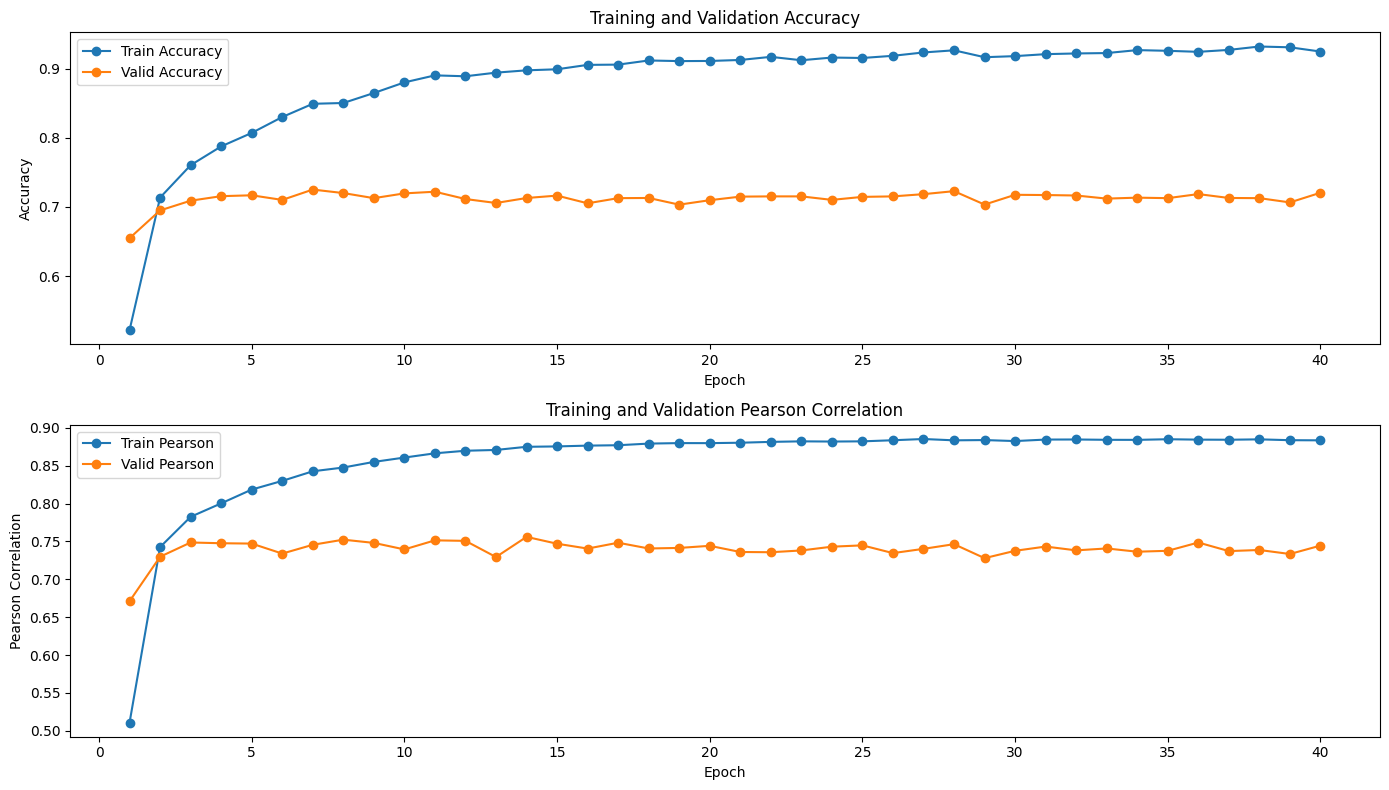

In [14]:
import matplotlib.pyplot as plt

def plot_metrics(metrics_history):
    epochs = range(1, len(metrics_history['train_accuracy']) + 1)

    plt.figure(figsize=(14, 8))

    # Plot accuracy
    plt.subplot(2, 1, 1)
    plt.plot(epochs, metrics_history['train_accuracy'], label='Train Accuracy', marker='o')
    plt.plot(epochs, metrics_history['valid_accuracy'], label='Valid Accuracy', marker='o')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Pearson correlation
    plt.subplot(2, 1, 2)
    plt.plot(epochs, metrics_history['train_pearson'], label='Train Pearson', marker='o')
    plt.plot(epochs, metrics_history['valid_pearson'], label='Valid Pearson', marker='o')
    plt.title('Training and Validation Pearson Correlation')
    plt.xlabel('Epoch')
    plt.ylabel('Pearson Correlation')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the train function and plot metrics
metrics_history = train()
plot_metrics(metrics_history)
